In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd CorrectAndWrong_TrainData_Run1/

/content/drive/MyDrive/CorrectAndWrong_TrainData_Run1


In [ ]:
ls

correct_true_fog.csv  correct_true_rem.npy  wrong_true_rem.csv
correct_true_fog.npy  wrong_true_fog.csv    wrong_true_rem.npy
correct_true_rem.csv  wrong_true_fog.npy


In [ ]:
import numpy as np
import pandas as pd

# Load .npy files containing preprocessed data
correct_true_rem = np.load("correct_true_rem.npy")
correct_true_fog = np.load("correct_true_fog.npy")
wrong_true_rem   = np.load("wrong_true_rem.npy")
wrong_true_fog   = np.load("wrong_true_fog.npy")

print("NPY shape (correct_true_rem):", correct_true_rem.shape)

# Load .csv files with channel labels and timepoints
correct_true_rem_df = pd.read_csv("correct_true_rem.csv", index_col=0)
correct_true_fog_df = pd.read_csv("correct_true_fog.csv", index_col=0)
wrong_true_rem_df   = pd.read_csv("wrong_true_rem.csv", index_col=0)
wrong_true_fog_df   = pd.read_csv("wrong_true_fog.csv", index_col=0)

print("CSV shape (correct_true_rem):", correct_true_rem_df.shape)

# Extract numpy array from DataFrame
arr_from_csv = correct_true_rem_df.values

NPY shape (correct_true_rem): (55, 100)
CSV shape (correct_true_rem): (55, 100)


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 32.5 MB/s eta 0:00:00


In [ ]:
# If needed:
# !pip install -q mne

import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

# ---------- Helper Functions ----------
def load_arr_and_channels(name, fallback_ch_names=None):
    """
    Loads an array from .npy and channel names from CSV index if available.
    Returns (arr, ch_names).
    """
    arr = np.load(f"{name}.npy")

    csv_path = f"{name}.csv"
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=0)
        ch_names = df.index.tolist()
    elif fallback_ch_names is not None:
        ch_names = list(fallback_ch_names)
    else:
        raise ValueError(
            f"'{csv_path}' not found and no fallback_ch_names provided. "
            "Load the CSV once or pass your ch_names explicitly."
        )
    return arr, ch_names


def channel_mean_over_time(arr):
    """Compute per-channel mean over timepoints. Expects shape [channels, timepoints]."""
    if arr.ndim != 2:
        raise ValueError(f"Expected 2D array [channels, timepoints], got shape {arr.shape}")
    return arr.mean(axis=1)


def prepare_topo_values(values, ch_names, montage_name="standard_1005", min_valid=5):
    """
    Filters channels to those present in the montage and returns
    (valid_values, valid_ch_names, info) ready for MNE topographic plotting.
    """
    montage = mne.channels.make_standard_montage(montage_name)
    known = set(montage.ch_names)

    valid_idx = [i for i, ch in enumerate(ch_names) if ch in known]
    valid_ch = [ch_names[i] for i in valid_idx]
    valid_vals = np.asarray([values[i] for i in valid_idx], dtype=float)

    if len(valid_ch) < min_valid:
        raise ValueError(
            f"Too few valid channels ({len(valid_ch)}). "
            f"Check your labels or try a different montage (e.g., 'standard_1020', 'standard_1005')."
        )

    info = mne.create_info(ch_names=valid_ch, sfreq=1000, ch_types='eeg')
    info.set_montage(montage)
    return valid_vals, valid_ch, info


def compute_shared_vlim(value_vectors):
    """
    Computes shared color scale limits (vmin, vmax) across multiple value vectors.
    Uses symmetric limits around zero if values span both positive and negative.
    """
    all_vals = np.concatenate(value_vectors)
    vmin, vmax = float(all_vals.min()), float(all_vals.max())
    # Use symmetric scale if crossing zero (helps visual comparison)
    if vmin < 0 < vmax:
        m = max(abs(vmin), abs(vmax))
        return (-m, m)
    return (vmin, vmax)


# ---------- Load Data for Four Categories ----------
correct_true_rem, ch_names = load_arr_and_channels("correct_true_rem")
correct_true_fog, _        = load_arr_and_channels("correct_true_fog", fallback_ch_names=ch_names)
wrong_true_rem, _          = load_arr_and_channels("wrong_true_rem",   fallback_ch_names=ch_names)
wrong_true_fog, _          = load_arr_and_channels("wrong_true_fog",   fallback_ch_names=ch_names)

# ---------- Compute Per-Channel Means ----------
v_rem_corr = channel_mean_over_time(correct_true_rem)
v_fog_corr = channel_mean_over_time(correct_true_fog)
v_rem_wrong = channel_mean_over_time(wrong_true_rem)
v_fog_wrong = channel_mean_over_time(wrong_true_fog)

In [ ]:
print(len(ch_names))

55


In [ ]:
ch_names = [
    'F5', 'F1', 'Fz', 'F2', 'F6', 'FFT7', 'FFT8', 'FTT9', 'FTT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FTT10', 'FTT8', 'FCC5', 'FCC3', 'FCC1', 'FCC2', 'FCC4', 'FCC6',
    'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TPP9', 'TPP7', 'CP5', 'CP3',
    'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TPP10', 'TPP8', 'P5', 'P3', 'Pz', 'P4', 'P6', 'PO7',
    'PO3', 'POz', 'PO4', 'PO8', 'Oz'
]

In [ ]:
def plot_four_topomaps_grid(v_rem_corr, v_rem_wrong, v_fog_corr, v_fog_wrong,
                            ch_names, montage_name="standard_1005", cmap="RdBu_r",
                            figsize=(10, 8), suptitle="Channel-wise mean importance"):
    """
    Plots 4 topographic maps in a 2x2 grid with shared color scale:
      [0,0] Remembered (Correct)    [0,1] Remembered (Incorrect)
      [1,0] Forgotten  (Correct)    [1,1] Forgotten  (Incorrect)
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import mne
    import numpy as np

    # Prepare data for each condition (filter channels by montage validity)
    def _prep(values):
        vals, valid_ch, info = prepare_topo_values(values, ch_names, montage_name=montage_name)
        evoked = mne.EvokedArray(vals[:, np.newaxis], info, tmin=0)
        return vals, evoked

    vals_rc, ev_rc = _prep(v_rem_corr)
    vals_ri, ev_ri = _prep(v_rem_wrong)
    vals_fc, ev_fc = _prep(v_fog_corr)
    vals_fi, ev_fi = _prep(v_fog_wrong)

    # Compute shared color scale limits (symmetric around zero if needed)
    vmin, vmax = compute_shared_vlim([vals_rc, vals_ri, vals_fc, vals_fi])
    norm = mpl.colors.Normalize(vmin=float(vmin), vmax=float(vmax))

    # Create 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=figsize, constrained_layout=True)
    titles = [
        "Remembered (Correct)",
        "Remembered (Incorrect)",
        "Forgotten  (Correct)",
        "Forgotten  (Incorrect)",
    ]
    ev_list = [ev_rc, ev_ri, ev_fc, ev_fi]

    # Plot each topomap without individual colorbars
    for ax, title, ev in zip(axs.ravel(), titles, ev_list):
        ev.plot_topomap(
            times=0,
            axes=ax,
            time_format="",
            size=3,
            cmap=cmap,
            scalings=dict(eeg=1.0),
            cnorm=norm,
            colorbar=False,
            show=False
        )
        ax.set_title(title, fontsize=11)

    # Add shared colorbar for all subplots
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), fraction=0.025, pad=0.03)
    cbar.set_label("Mean importance (a.u.)")

    fig.suptitle("Topomaps (mean over timepoints)", fontsize=13)
    plt.show()

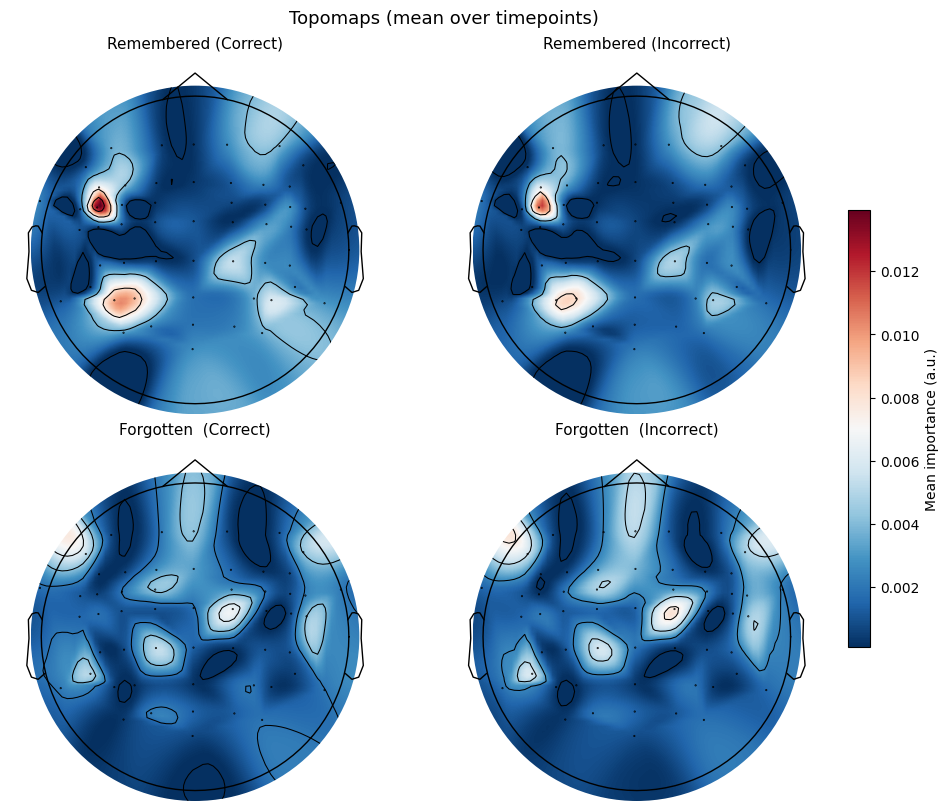

In [ ]:
# Plot topographic maps for all four conditions with shared color scale
plot_four_topomaps_grid(
    v_rem_corr=v_rem_corr,
    v_rem_wrong=v_rem_wrong,
    v_fog_corr=v_fog_corr,
    v_fog_wrong=v_fog_wrong,
    ch_names=ch_names,
    montage_name="standard_1005"
)

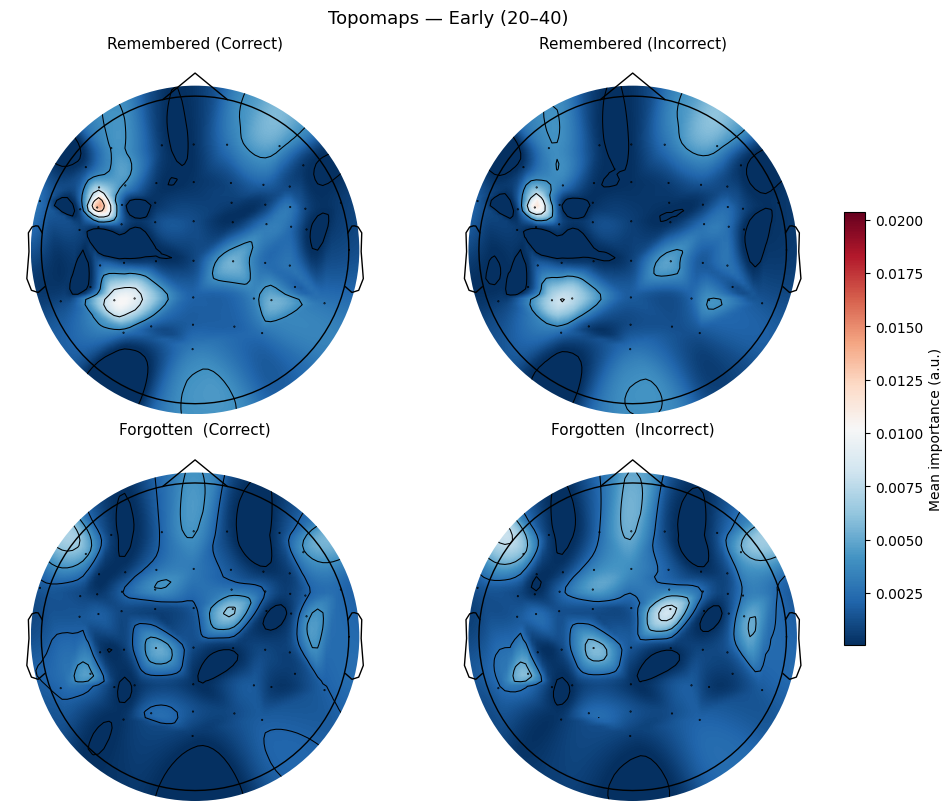

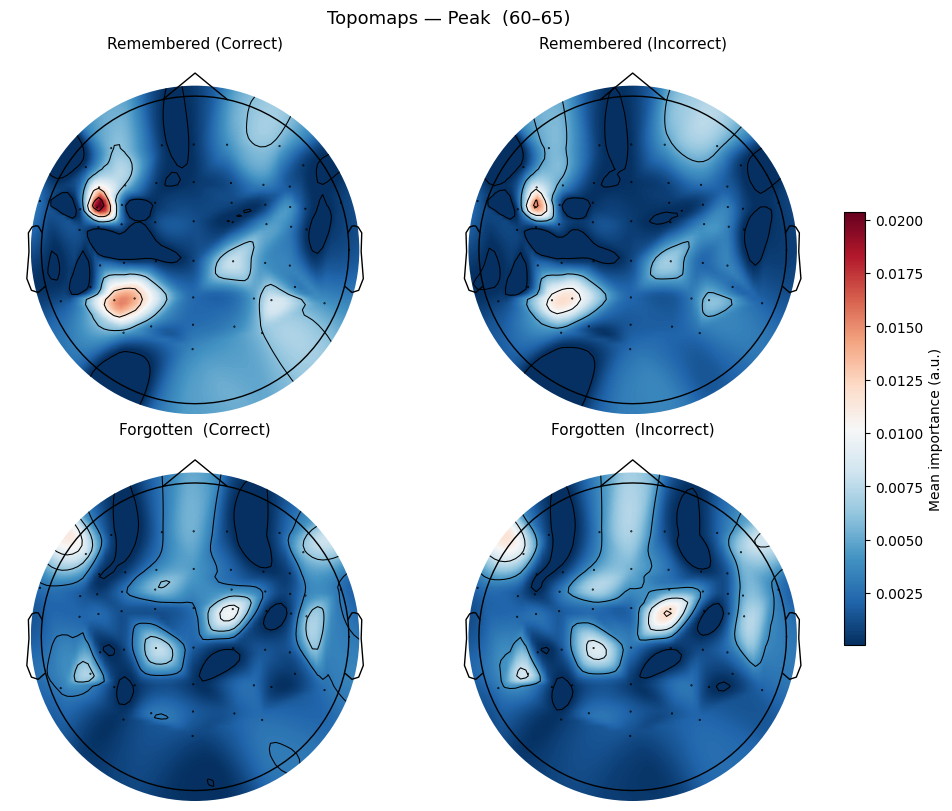

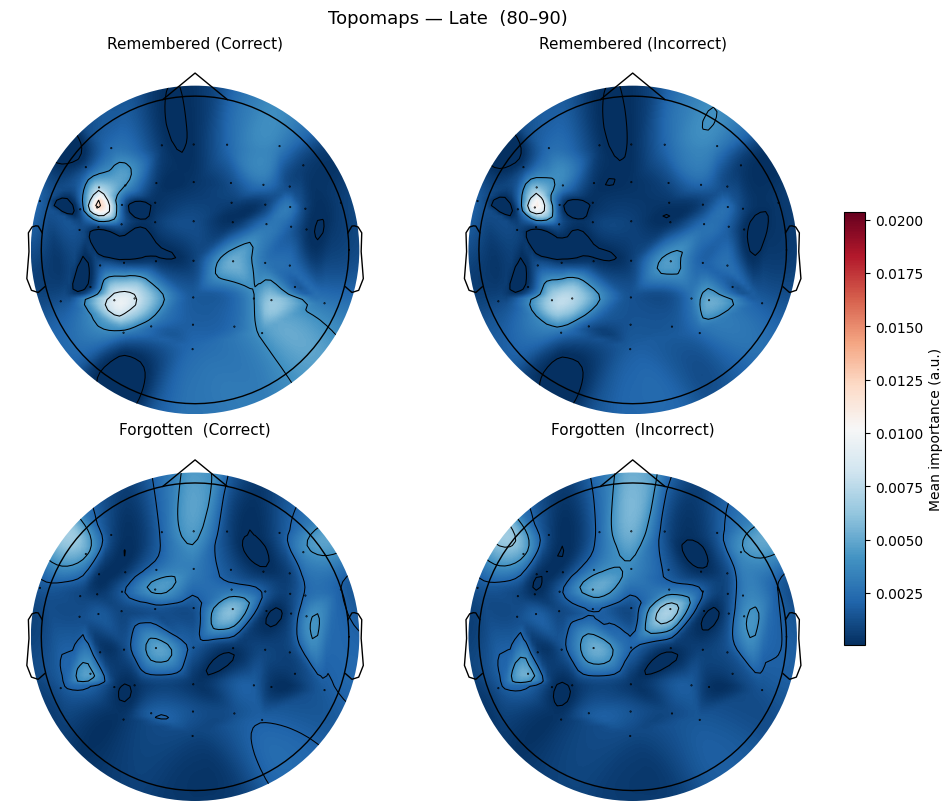

In [ ]:
# Compute mean over a time window, returns per-channel vector
def window_mean(arr, t0, t1):
    """Average array values over time window [t0:t1). Expects shape [channels, timepoints]."""
    return arr[:, t0:t1].mean(axis=1)


def plot_four_topomaps_grid(v_rem_corr, v_rem_wrong, v_fog_corr, v_fog_wrong,
                            ch_names, montage_name="standard_1005", cmap="RdBu_r",
                            figsize=(10, 8), suptitle="Channel-wise mean importance",
                            vlim_override=None):
    """
    Plots 4 topographic maps in a 2x2 grid with shared color scale.
    If vlim_override=(vmin, vmax) is provided, uses it for cross-figure comparability.
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import mne
    import numpy as np

    def _prep(values):
        vals, valid_ch, info = prepare_topo_values(values, ch_names, montage_name=montage_name)
        evoked = mne.EvokedArray(vals[:, np.newaxis], info, tmin=0)
        return vals, evoked

    vals_rc, ev_rc = _prep(v_rem_corr)
    vals_ri, ev_ri = _prep(v_rem_wrong)
    vals_fc, ev_fc = _prep(v_fog_corr)
    vals_fi, ev_fi = _prep(v_fog_wrong)

    # Determine color scale limits
    if vlim_override is None:
        vmin, vmax = compute_shared_vlim([vals_rc, vals_ri, vals_fc, vals_fi])
    else:
        vmin, vmax = vlim_override
    norm = mpl.colors.Normalize(vmin=float(vmin), vmax=float(vmax))

    fig, axs = plt.subplots(2, 2, figsize=figsize, constrained_layout=True)
    titles = ["Remembered (Correct)", "Remembered (Incorrect)", "Forgotten  (Correct)", "Forgotten  (Incorrect)"]
    ev_list = [ev_rc, ev_ri, ev_fc, ev_fi]

    for ax, title, ev in zip(axs.ravel(), titles, ev_list):
        ev.plot_topomap(times=0, axes=ax, time_format="", size=3, cmap=cmap,
                        scalings=dict(eeg=1.0), cnorm=norm, colorbar=False, show=False)
        ax.set_title(title, fontsize=11)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), fraction=0.025, pad=0.03)
    cbar.set_label("Mean importance (a.u.)")

    fig.suptitle(suptitle, fontsize=13)
    plt.show()


# Define time windows for analysis
wins = {
    "Early (20–40)": (20, 40),
    "Peak  (60–65)": (60, 65),
    "Late  (80–90)": (80, 90),
}

# Compute per-channel means for each time window
vecs_all = []
store = {}
for label, (t0, t1) in wins.items():
    v_rc = window_mean(correct_true_rem, t0, t1)
    v_fc = window_mean(correct_true_fog, t0, t1)
    v_ri = window_mean(wrong_true_rem,   t0, t1)
    v_fi = window_mean(wrong_true_fog,   t0, t1)
    store[label] = (v_rc, v_ri, v_fc, v_fi)
    vecs_all.extend([v_rc, v_ri, v_fc, v_fi])

# Compute global color scale limits for consistent comparison across time windows
global_vmin, global_vmax = compute_shared_vlim(vecs_all)

# Plot topomaps for each time window with shared color scale
for label in ["Early (20–40)", "Peak  (60–65)", "Late  (80–90)"]:
    v_rc, v_ri, v_fc, v_fi = store[label]
    plot_four_topomaps_grid(
        v_rem_corr=v_rc,
        v_rem_wrong=v_ri,
        v_fog_corr=v_fc,
        v_fog_wrong=v_fi,
        ch_names=ch_names,
        montage_name="standard_1005",
        suptitle=f"Topomaps — {label}",
        vlim_override=(global_vmin, global_vmax)
    )

In [ ]:
def plot_topomap_three_rows_windows(
    values_rc,                 # [C, T] Remembered (Correct)
    values_fc,                 # [C, T] Forgotten  (Correct)
    ch_names,
    windows,                   # list of (t0, t1) in samples
    montage_name="standard_1005",
    row_titles=("Remembered", "Forgotten", "Rem − Forg"),
    fs=100,
    cmap="Reds",               # kept for backward compatibility, not used directly
    figsize=(12, 6),
    vlim_override=None,        # (vmin, vmax) for rows 1-2 (shared)
    diff_vlim_override=None,   # (vmin, vmax) for row 3
    symmetric_diff=True,       # make row 3 symmetric around 0
    row_cmaps=None             # (<cmap_row1>, <cmap_row2>, <cmap_row3>)
):
    """
    Plots 3 rows of topomaps across identical time windows.
    Rows 1-2: single-tone white-to-red colormap
    Row 3: bipolar blue-to-red colormap for difference
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import mne
    import numpy as np
    from matplotlib.colors import TwoSlopeNorm

    # Default colormaps: white-red for rows 1-2, diverging for row 3
    if row_cmaps is None:
        row_cmaps = (mpl.cm.Reds, mpl.cm.Reds, mpl.cm.RdBu_r)

    def window_mean(arr, t0, t1):
        return arr[:, t0:t1].mean(axis=1)

    # Compute windowed means for each condition
    vecs_rc, vecs_fc, vecs_diff = [], [], []
    ev_rc, ev_fc, ev_diff = [], [], []
    titles = []

    for (t0, t1) in windows:
        # Remembered (Correct)
        v1 = window_mean(values_rc, t0, t1)
        vals1, _, info1 = prepare_topo_values(v1, ch_names, montage_name=montage_name)
        ev1 = mne.EvokedArray(vals1[:, np.newaxis], info1, tmin=0)
        vecs_rc.append(vals1); ev_rc.append(ev1)

        # Forgotten (Correct)
        v2 = window_mean(values_fc, t0, t1)
        vals2, _, info2 = prepare_topo_values(v2, ch_names, montage_name=montage_name)
        ev2 = mne.EvokedArray(vals2[:, np.newaxis], info2, tmin=0)
        vecs_fc.append(vals2); ev_fc.append(ev2)

        # Difference
        diff = vals1 - vals2
        vecs_diff.append(diff)
        ev3 = mne.EvokedArray(diff[:, np.newaxis], info1, tmin=0)
        ev_diff.append(ev3)

        # Convert time window to milliseconds for labels
        t0_ms = int(round((t0 * 1000) / fs))
        t1_ms = int(round((t1 * 1000) / fs))
        titles.append(f"{t0_ms}–{t1_ms} ms")

    # Compute color scale limits
    def _minmax(arrs):
        vmin = min(float(np.nanmin(a)) for a in arrs)
        vmax = max(float(np.nanmax(a)) for a in arrs)
        return vmin, vmax

    # Rows 1-2: fixed lower bound at 0 for white-to-red colormap
    if vlim_override is None:
        _, vmax_pos = _minmax(vecs_rc + vecs_fc)
        vmin_all, vmax_all = 0.0, vmax_pos if vmax_pos > 0 else 1e-9
    else:
        vmin_all, vmax_all = vlim_override
    norm_all = mpl.colors.Normalize(vmin=vmin_all, vmax=vmax_all)

    # Row 3: difference with optional symmetric scaling
    if diff_vlim_override is not None:
        vmin_d, vmax_d = diff_vlim_override
        norm_diff = (TwoSlopeNorm(vmin=vmin_d, vcenter=0.0, vmax=vmax_d)
                     if symmetric_diff else mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d))
    else:
        vmin_d, vmax_d = _minmax(vecs_diff)
        if symmetric_diff:
            m = max(abs(vmin_d), abs(vmax_d))
            norm_diff = TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)
            vmin_d, vmax_d = -m, m
        else:
            norm_diff = mpl.colors.Normalize(vmin=vmin_d, vmax=vmax_d)

    # Create figure with 3 rows
    n = len(windows)
    fig, axs = plt.subplots(3, n, figsize=figsize, constrained_layout=True)
    axs = np.atleast_2d(axs)

    # Helper function to plot a single row
    def _plot_row(ax_row, ev_list, row_title, norm, cmap_row):
        for ax, ev, col_title in zip(ax_row, ev_list, titles):
            ev.plot_topomap(times=0, axes=ax, time_format="", size=3,
                            cmap=cmap_row, scalings=dict(eeg=1.0),
                            cnorm=norm, colorbar=False, show=False)
            ax.set_title(col_title, fontsize=10)
        ax_row[0].text(-0.12, 0.5, row_title, transform=ax_row[0].transAxes,
                       rotation=90, va='center', ha='right', fontsize=11)

    # Plot all three rows
    _plot_row(axs[0], ev_rc,   row_titles[0], norm_all,  row_cmaps[0])
    _plot_row(axs[1], ev_fc,   row_titles[1], norm_all,  row_cmaps[1])
    _plot_row(axs[2], ev_diff, row_titles[2], norm_diff, row_cmaps[2])

    # Add colorbars: one for rows 1-2, one for row 3
    sm_all  = mpl.cm.ScalarMappable(norm=norm_all,  cmap=row_cmaps[0]); sm_all.set_array([])
    sm_diff = mpl.cm.ScalarMappable(norm=norm_diff, cmap=row_cmaps[2]); sm_diff.set_array([])

    cbar1 = fig.colorbar(sm_all,  ax=axs[0:2, :].ravel().tolist(), fraction=0.03, pad=0.02)
    cbar1.set_label("Mean importance (a.u.)")
    cbar2 = fig.colorbar(sm_diff, ax=axs[2, :].ravel().tolist(), fraction=0.03, pad=0.02)
    cbar2.set_label("RC − FC (a.u.)")

    # Add title and panel labels
    fig.suptitle("Topomaps across time windows", fontsize=13)
    fig.text(0.005, 0.93, "A", fontsize=16, weight="bold")
    fig.text(0.005, 0.61, "B", fontsize=16, weight="bold")
    fig.text(0.005, 0.29, "C", fontsize=16, weight="bold")
    plt.show()

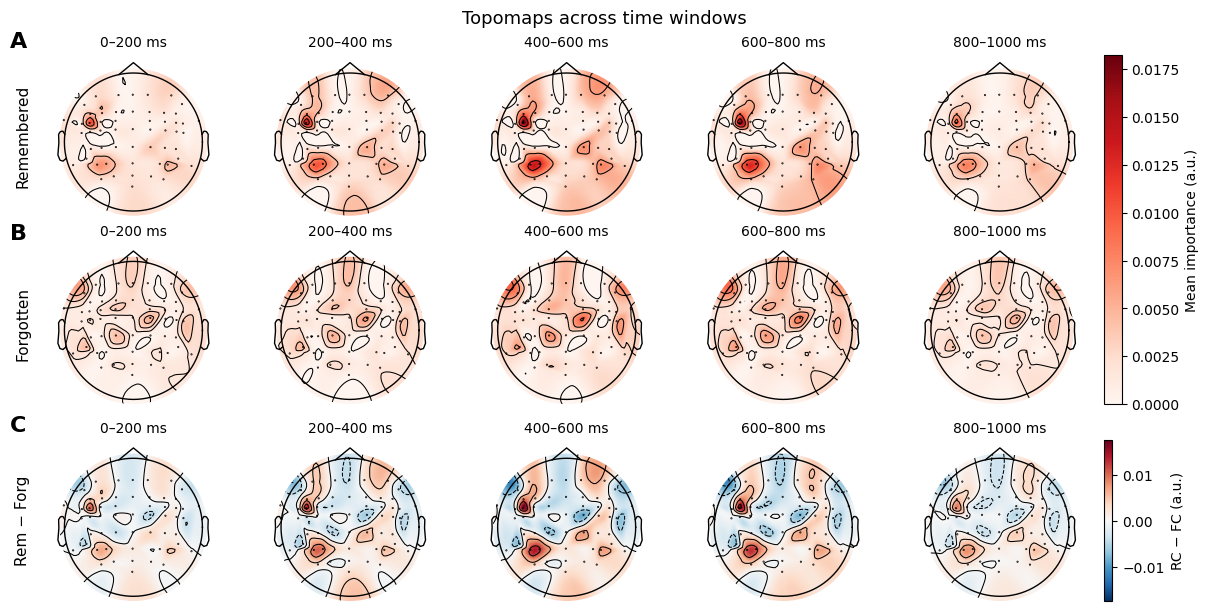

In [ ]:
import numpy as np

# Define time windows in samples for analysis
windows = [(0,20), (20,40), (40,60), (60,80), (80,100)]

# Compute symmetric color scale limits for difference row
diff_vals = []
for (t0, t1) in windows:
    rc_vec = correct_true_rem[:, t0:t1].mean(axis=1)
    fc_vec = correct_true_fog[:, t0:t1].mean(axis=1)
    diff_vals.append(rc_vec - fc_vec)
diff_vlim = (-np.max(np.abs(np.concatenate(diff_vals))),
              np.max(np.abs(np.concatenate(diff_vals))))

# Plot three-row topographic maps across time windows
plot_topomap_three_rows_windows(
    values_rc=correct_true_rem,
    values_fc=correct_true_fog,
    ch_names=ch_names,
    windows=windows,
    row_cmaps=(plt.cm.Reds, plt.cm.Reds, plt.cm.RdBu_r)  # optional: default values
)

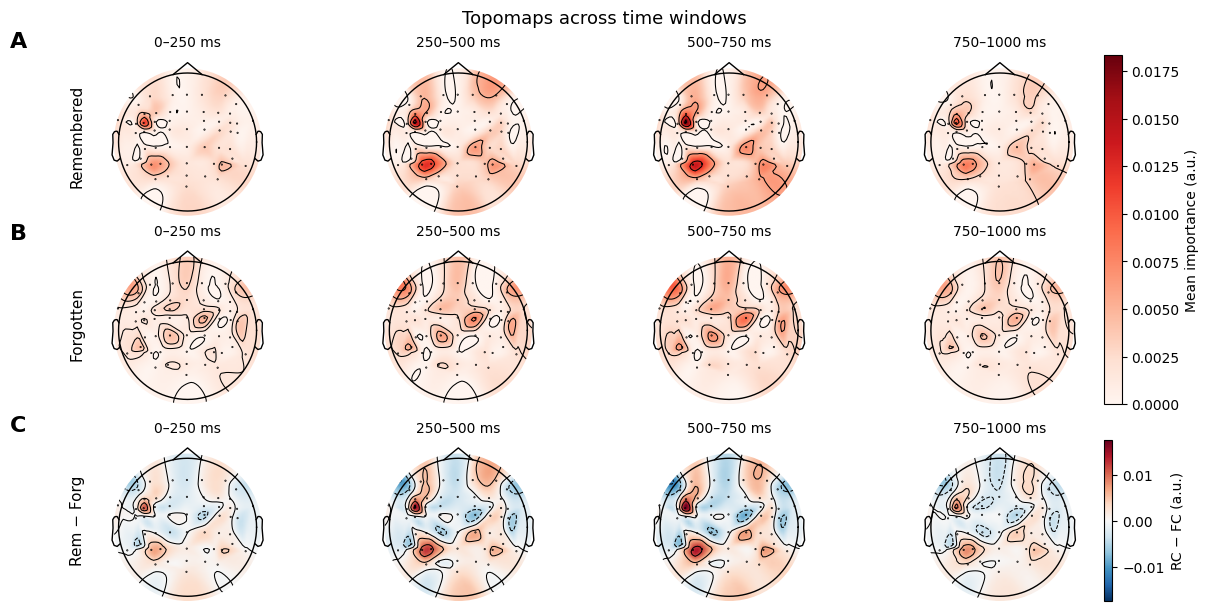

In [ ]:
import numpy as np

# Define time windows in samples for analysis
windows = [(0,25), (25,50), (50,75), (75,100)]

# Compute symmetric color scale limits for difference row
diff_vals = []
for (t0, t1) in windows:
    rc_vec = correct_true_rem[:, t0:t1].mean(axis=1)
    fc_vec = correct_true_fog[:, t0:t1].mean(axis=1)
    diff_vals.append(rc_vec - fc_vec)
diff_vlim = (-np.max(np.abs(np.concatenate(diff_vals))),
              np.max(np.abs(np.concatenate(diff_vals))))

# Plot three-row topographic maps across time windows
plot_topomap_three_rows_windows(
    values_rc=correct_true_rem,
    values_fc=correct_true_fog,
    ch_names=ch_names,
    windows=windows,
    row_cmaps=(plt.cm.Reds, plt.cm.Reds, plt.cm.RdBu_r)  # optional: default values
)